In [1]:
from datetime import date
from nsepy import get_history as gh
import dateutil.relativedelta as dr
import matplotlib.pyplot as plt
import pandas as pd
import xlsxwriter as xl
import datetime as dt
tradingsymbol = 'NIFTY'

In [2]:
entry_date = date(2021, 8, 20)
expirtydate = date(2021, 12, 30)
end = dt.datetime.today()
days = pd.date_range(entry_date, end,freq='d').value_counts().count()
start = end - dr.relativedelta(days=int(days)-1)

srtickprice = 17500
lot_size = 500

niftyCEData = gh(symbol=tradingsymbol,
                     start=start,
                     end=end,
                     index=True,
                     option_type="CE",
                     strike_price=srtickprice,
                     expiry_date=expirtydate)

In [3]:
niftyCEData.rename(columns = {'Close':'Close_CE','Option Type':'Option Type_CE'}, inplace = True)

In [4]:
niftyCEData =niftyCEData.loc[:,['Symbol', 'Strike Price', 'Close_CE','Expiry','Option Type_CE']].sort_index()

In [5]:
niftyPEData = gh(symbol=tradingsymbol,
                     start=start,
                     end=end,
                     index=True,
                     option_type="PE",
                     strike_price=srtickprice,
                     expiry_date=expirtydate)
niftyPEData.rename(columns = {'Close':'Close_PE','Option Type':'Option Type_PE'}, inplace = True)

niftyPEData = niftyPEData.loc[:,['Symbol', 'Strike Price', 'Close_PE','Expiry','Option Type_PE']].sort_index()

In [6]:
file_name = 'MarksData.xlsx'
result = pd.concat([niftyCEData, niftyPEData], axis=1)
final = result.loc[:,~result.columns.duplicated()]
final =final.loc[:,['Symbol','Expiry','Option Type_CE','Close_CE','Strike Price','Close_PE','Option Type_PE']]



In [7]:
nifty_50 = gh(symbol="NIFTY",
                            start=start,
                            end=end,
                            index=True)
nifty_50.rename(columns = {'Close':'Close_Nifty'}, inplace = True)
nifty_50 = nifty_50.loc[:,['Close_Nifty','Volume']]
options = pd.concat([final, nifty_50], axis=1)
options['Total Premium'] = options['Close_CE'] + options['Close_PE']
entrydate_prm =options.filter(items = [entry_date], axis=0)['Total Premium']
options['Entry Date Prem'] = entrydate_prm.values[0]
options['Profit/Loss per lot'] = (options['Entry Date Prem'] - options['Total Premium'])*lot_size

In [8]:
vix = gh(symbol="INDIAVIX",
                  start=start,
                  end=end,
                  index=True)
vix.rename(columns = {'Close':'Close_VIX'}, inplace = True)
vix =vix.loc[:,['Close_VIX']].dropna()
options_withVix = pd.concat([options, vix], axis=1).sort_index()

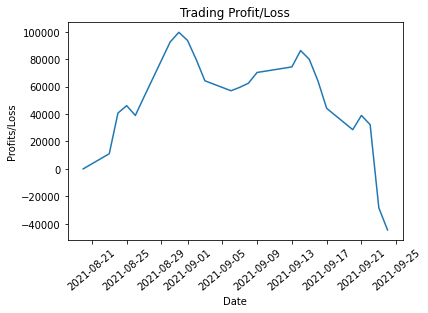

In [9]:
#writer = pd.ExcelWriter(file_name, engine='xlsxwriter')
loc = "C:\\Users\\Srikanth.Chippa\\"
plt.plot(options_withVix.index.values,  options_withVix["Profit/Loss per lot"])
plt.ylabel("Profits/Loss")
plt.xlabel("Date")
plt.xticks(rotation =40)
plt.title("Trading Profit/Loss")
plt.savefig(loc+"Trading.png",dpi=300, bbox_inches='tight')

In [10]:
df = pd.DataFrame();

with pd.ExcelWriter(file_name) as writer:
    options_withVix.to_excel(writer, sheet_name='Sheet2')
    df.to_excel(writer, sheet_name='Sheet3')
    workbook  = writer.book
    worksheet = writer.sheets['Sheet2']
    worksheet3 = writer.sheets['Sheet3']
    
    worksheet3.insert_image(1, df.shape[1]+2, loc+"Trading.png")

    cell_format = workbook.add_format()
    cell_format.set_border()
    cell_format.set_bg_color('green')
    cell_format.set_font_color('#FFFFFF')
    cell_format.set_font_size(12)


    cell_format1 = workbook.add_format()
    cell_format1.set_border()
    cell_format1.set_bg_color('#FF00FF')
    cell_format1.set_font_color('#FFFFFF')
    cell_format1.set_font_size(12)

    entrydate_format1 = workbook.add_format()
    entrydate_format1.set_border()
    entrydate_format1.set_bg_color('#CCFFCC')
    entrydate_format1.set_font_size(14)

    cell_format2 = workbook.add_format()
    cell_format2.set_bg_color('yellow')

    cell_format3 = workbook.add_format()
    cell_format3.set_border()
    cell_format3.set_bg_color('#000080')
    cell_format3.set_font_size(12)
    cell_format3.set_font_color('#FFFFFF')

    cell_format4 = workbook.add_format()
    cell_format4.set_border()
    cell_format4.set_bg_color('#800000')
    cell_format4.set_font_size(12)
    cell_format4.set_font_color('#FFFFFF')

    cell_format5 = workbook.add_format()
    cell_format5.set_border()
    cell_format5.set_font_size(12)
    cell_format5.set_font_color('red')

    worksheet.set_column('A:N', 18, cell_format2)
    worksheet.set_column('E:E', 18, cell_format)
    worksheet.set_column('G:G', 18, cell_format1)
    worksheet.set_column('I:I', 18, cell_format3)
    worksheet.set_column('M:M', 18, cell_format4)
    worksheet.set_column('N:N', 18, cell_format5)
    worksheet.freeze_panes(1, 0)
    worksheet.write_comment('A2', 'Entry Trade date', {'font_size': 14, 'color': '#CCFFCC'})

    worksheet.autofilter('A1:N500')

    worksheet.conditional_format('A1:A500', {'type': 'date',
                                        'criteria': '==',
                                        'value':    entry_date,
                                        'format':   entrydate_format1})
    writer.save()


c:\etap 2060\thirdparty\python\python384\lib\site-packages\xlsxwriter\workbook.py:338: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
